              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       1.494309      0.007542      0.234303      3.409430      7.656873   
std        0.539989      0.086517      0.766318    

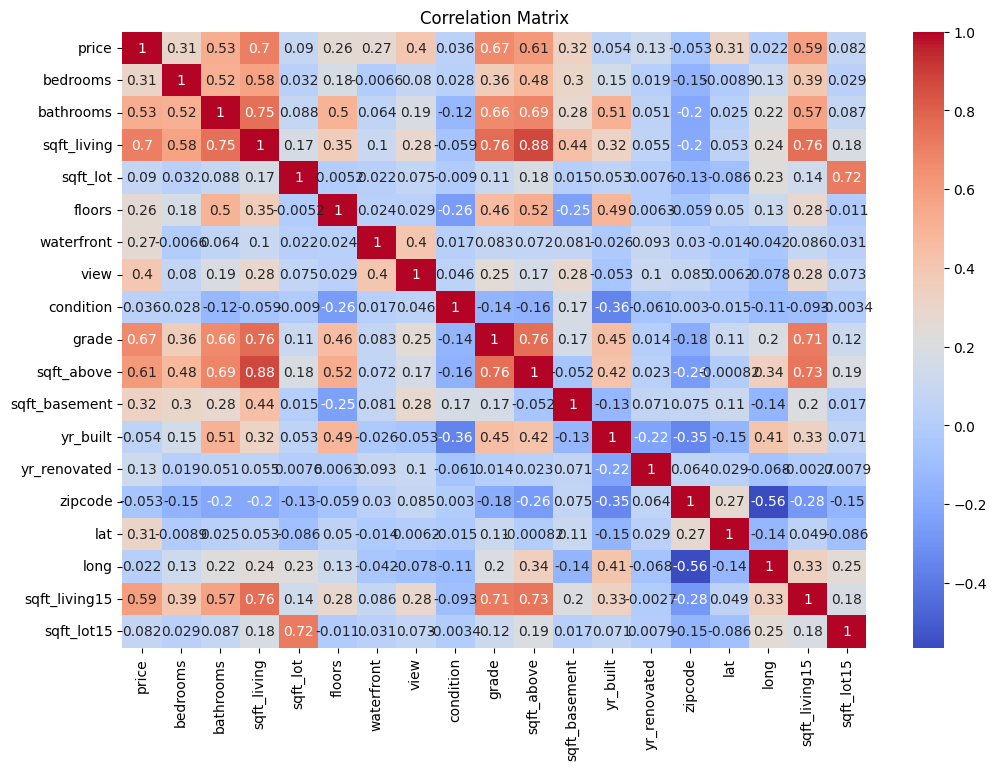

Cross-Validation R-squared Scores: [0.79413772 0.85322894 0.78074575]
Mean Cross-Validation R-squared: 0.8093708041741247
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best Model - Mean Squared Error: 24937591497.279823
Best Model - R-squared: 0.835043432781435


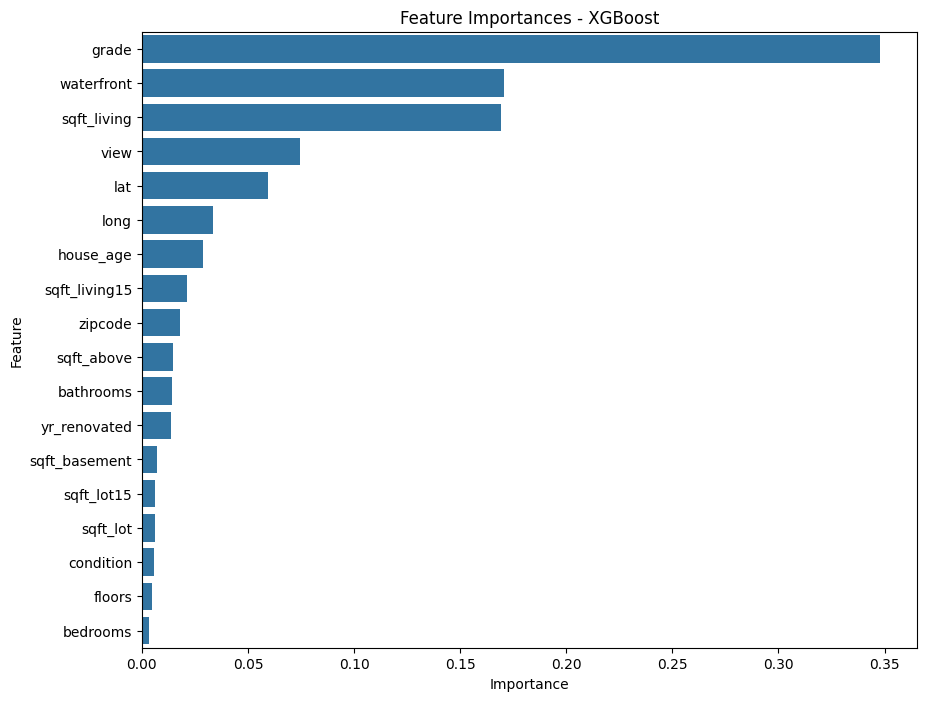

Validation - Mean Squared Error: 14071391353.578455
Validation - R-squared: 0.8817649822657945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 18
[LightGBM] [Info] Start training from score 537768.047947
LightGBM - Mean Squared Error: 18781498329.786945
LightGBM - R-squared: 0.8757646065362483
CatBoost - Mean Squared Error: 14010260781.072918
CatBoost - R-squared: 0.9073252713865823


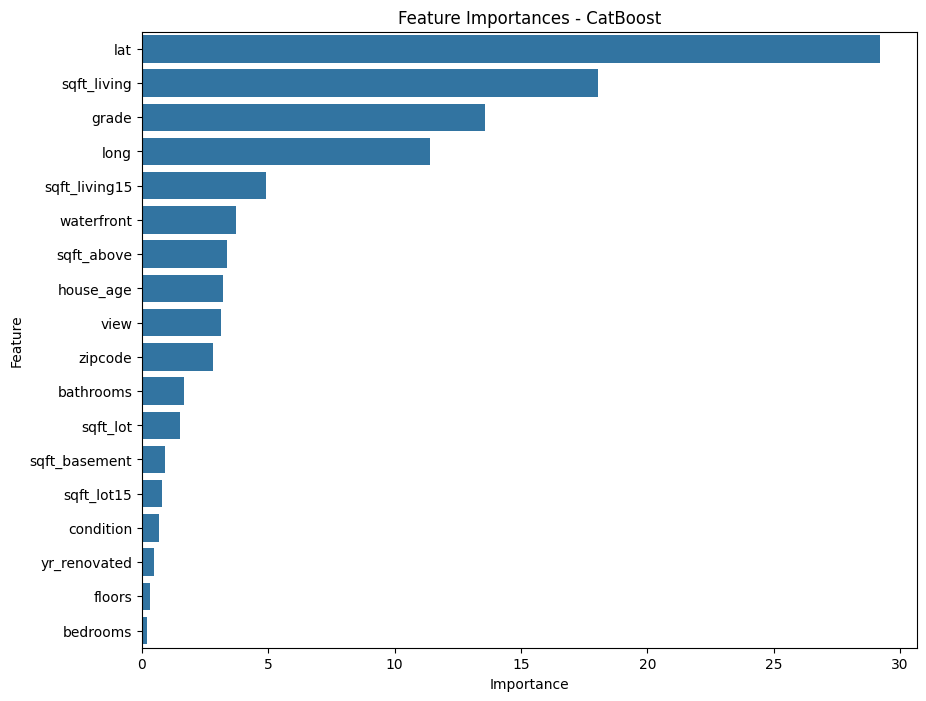

Loaded CatBoost Model - Mean Squared Error: 14010260781.072918
Loaded CatBoost Model - R-squared: 0.9073252713865823


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import numpy as np
import joblib

# Load the dataset from CSV
df = pd.read_csv('dataSet/house_data.csv')

# Drop unwanted columns
df = df.drop(['id', 'date'], axis=1)

# Exploratory Data Analysis (EDA)
# Summary statistics of the dataset
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Correlation matrix to understand feature relationships
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering: Example of creating a new feature
df['house_age'] = 2023 - df['yr_built']

# Drop the original 'yr_built' column if necessary
df = df.drop(['yr_built'], axis=1)

# Preprocessing: Selecting features and target variable
X = df.copy().drop('price', axis=1)
y = df['price']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reducing the dataset size for quick demonstration
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# XGBoost Model with Cross-Validation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
cross_val_scores = cross_val_score(xgb_model, X_train_small, y_train_small, cv=3, scoring='r2')

print("Cross-Validation R-squared Scores:", cross_val_scores)
print("Mean Cross-Validation R-squared:", np.mean(cross_val_scores))

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search.fit(X_train_small, y_train_small)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best Model - Mean Squared Error:", mse_best)
print("Best Model - R-squared:", r2_best)

# Feature Importance for XGBoost
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances - XGBoost')
plt.show()

# Additional Model Validation using a holdout validation set
# Split the training set into new training and validation sets
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model on the new training set
best_model.fit(X_train_new, y_train_new)

# Evaluate the model on the validation set
y_pred_val = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("Validation - Mean Squared Error:", mse_val)
print("Validation - R-squared:", r2_val)

# LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM - Mean Squared Error:", mse_lgb)
print("LightGBM - R-squared:", r2_lgb)

# CatBoost model
catboost_model = CatBoostRegressor(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print("CatBoost - Mean Squared Error:", mse_catboost)
print("CatBoost - R-squared:", r2_catboost)

# Feature Importance for CatBoost
feature_importances_catboost = catboost_model.get_feature_importance(Pool(X_train, y_train))
importance_df_catboost = pd.DataFrame({'Feature': features, 'Importance': feature_importances_catboost})
importance_df_catboost = importance_df_catboost.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_catboost)
plt.title('Feature Importances - CatBoost')
plt.show()

# Save the CatBoost model
joblib.dump(catboost_model, 'catboost_house_price_model.pkl')

# Load the CatBoost model
loaded_catboost_model = joblib.load('catboost_house_price_model.pkl')

# Make predictions with the loaded model
y_pred_loaded_catboost = loaded_catboost_model.predict(X_test)
print("Loaded CatBoost Model - Mean Squared Error:", mean_squared_error(y_test, y_pred_loaded_catboost))
print("Loaded CatBoost Model - R-squared:", r2_score(y_test, y_pred_loaded_catboost))
